# Library

In [34]:
import pandas as pd
import numpy as np
import json
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    TimeSeriesSplit,
)
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as ds
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [14]:
def convert_category_into_integer(df: pd.DataFrame, columns: list):
    label_encoders = {}
    for column in columns:
        label_encoder = LabelEncoder()
        df.loc[:, column] = label_encoder.fit_transform(df[column])

        label_encoders.update({column: label_encoder})
    
    return df, label_encoders

# Metrics

특정한 성과나 특성을 수치적으로 측정하고 평가하는 방법이나 기준. <br>
classificaiton task에서는 accuracy, F1 등이 존재

## Confusion Matrix

<img src="https://images.prismic.io/encord/edfa849b-03fb-43d2-aba5-1f53a8884e6f_image5.png?auto=compress,format" width="600" height="300"/>

혼동 행렬(confusion matrix)은 분류 모델의 성능을 평가하기 위해 사용되는 표 형식의 도구 <br>
모델의 예측 결과와 실제 값을 비교하여 각 클래스에 대한 정확한 예측과 잘못된 예측의 수를 시각적으로 표현 <br>

<br>

<font style="font-size:20px"> 구성 요소 </font> <br>
- True Positive (TP): 실제 양성 클래스를 모델이 올바르게 양성으로 예측한 수
- True Negative (TN): 실제 음성 클래스를 모델이 올바르게 음성으로 예측한 수
- False Positive (FP): 실제 음성 클래스를 모델이 잘못 양성으로 예측한 수 (Type I error)
- False Negative (FN): 실제 양성 클래스를 모델이 잘못 음성으로 예측한 수 (Type II error)

### Accuracy

전체 샘플 중에서 모델이 올바르게 분류한 샘플의 비율

$$
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
$$

<br>

<font style="font-size:16px"> 특징 </font> <br>

모든 클래스의 균형이 잡혀 있을 때 좋은 지표. <br>
1에 가까울수록 모델의 성능이 좋음. <br>
클래스 불균형이 심할 경우, 정확도는 오해를 불러일으킬 수 있음. <br>
&nbsp;&nbsp;&nbsp;&nbsp; ex) 99.99%의 샘플이 음성이고 0.01%가 양성인 경우, 모델이 항상 음성으로 예측하더라도 99.99%의 정확도를 보일 수 있음

### Precision

모델이 양성으로 예측한 샘플 중 실제로 양성인 샘플의 비율 <br>

<br>

$$
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

<br>

<font style="font-size:16px"> 특징 </font> <br>
정밀도(precision)가 높으면 모델이 양성으로 예측한 결과가 신뢰할 수 있다는 의미. 즉, 잘못된 긍정 예측(FP)이 적음. <br>
1에 가까울수록 모델의 성능이 좋음. <br>
기존 시스템에서 오분류가 심각할 경우 주요 지표로 활용. <br>
&nbsp;&nbsp;&nbsp;&nbsp; ex) 정상 메일 중 스팸 메일로 분류되는 비율이 높은 시스템을 개선할 때. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 암 진단에서 기존 모델이 암이 아닌데도 암이라고 예측하는 시스템을 개선하는 경우. <br> 

### Recall

실제 양성 샘플 중 모델이 양성으로 올바르게 예측한 비율 <br>

<br>

$$
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

<font style="font-size:16px"> 특징 </font> <br>
재현율(recall)이 높으면 모델의 검출력이 좋다는 의미. <br>
1에 가까울수록 모델의 성능이 좋음. <br>
특정 현상을 검출하는 것이 중요할 때 활용. <br>
&nbsp;&nbsp;&nbsp;&nbsp; ex) default 위험을 조기진단 할 때 default를 예측하지 못하는 경우 시스템 붕괴로 이어질 수 있음. <br>



### F1

정밀도(Precision)와 재현율(Recall)의 조화 평균. <br>
두 지표 간의 균형을 중요시할 때 사용. <br>

<br>

$$
\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

<br>

<font style="font-size:16px"> 특징 </font> <br>

클래스 불균형이 심할 때 유용. <br>
1에 가까울수록 모델의 성능이 좋음. <br>

In [74]:
titanic = sns.load_dataset('titanic')
titanic.deck = titanic.deck.astype(str)
titanic = titanic.drop(columns=['alive'])
titanic = titanic.dropna()
titanic = titanic.reset_index()

In [75]:
titanic.sex = titanic.sex.astype('category')
titanic.embarked = titanic.embarked.astype('category')
titanic['class'] = titanic['class'].astype('category')
titanic.who = titanic.who.astype('category')
titanic.adult_male = titanic.adult_male.astype('category')
titanic.deck = titanic.deck.astype('category')
titanic.embark_town = titanic.embark_town.astype('category')
titanic.alone = titanic.alone.astype('category')
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   index        712 non-null    int64   
 1   survived     712 non-null    int64   
 2   pclass       712 non-null    int64   
 3   sex          712 non-null    category
 4   age          712 non-null    float64 
 5   sibsp        712 non-null    int64   
 6   parch        712 non-null    int64   
 7   fare         712 non-null    float64 
 8   embarked     712 non-null    category
 9   class        712 non-null    category
 10  who          712 non-null    category
 11  adult_male   712 non-null    category
 12  deck         712 non-null    category
 13  embark_town  712 non-null    category
 14  alone        712 non-null    category
dtypes: category(8), float64(2), int64(5)
memory usage: 45.8 KB


In [22]:
seed = 0
train, temp = train_test_split(titanic, test_size=0.4, random_state=seed)
valid, test = train_test_split(temp, test_size=0.5, random_state=seed)

In [ ]:
lgbm = LGBMClassifier(verbose=0)
lgbm.fit(
    train.drop(columns=['survived']), train.survived,
    eval_set=(valid.drop(columns=['survived']), valid.survived)
)

In [28]:
lgbm.score(test.drop(columns=['survived']), test.survived)

0.7972027972027972

In [32]:
print(
    classification_report(
        test.survived,
        lgbm.predict(test.drop(columns=['survived'])),
    )
)

              precision    recall  f1-score   support

           0       0.83      0.84      0.83        86
           1       0.75      0.74      0.74        57

    accuracy                           0.80       143
   macro avg       0.79      0.79      0.79       143
weighted avg       0.80      0.80      0.80       143



In [35]:
confusion_matrix(
    test.survived,
    lgbm.predict(test.drop(columns=['survived'])),
)

array([[72, 14],
       [15, 42]], dtype=int64)

In [40]:
# target: 0 
acc = (72+42) / (72+14+15+42)
precision = 72 / (72+15)
recall = 72 / (72+14)
f1 = 2*precision*recall / (precision+recall)

print(f'acc: {acc*100: .2f}%')
print(f'precision: {precision*100: .2f}%')
print(f'recall: {recall*100: .2f}%')
print(f'f1: {f1*100: .2f}%')

acc:  79.72%
precision:  82.76%
recall:  83.72%
f1:  83.24%


In [43]:
# target: 1 
acc = (72+42) / (72+14+15+42)
precision = 42 / (42+14)
recall = 42 / (42+15)
f1 = 2*precision*recall / (precision+recall)

print(f'acc: {acc*100: .2f}%')
print(f'precision: {precision*100: .2f}%')
print(f'recall: {recall*100: .2f}%')
print(f'f1: {f1*100: .2f}%')

acc:  79.72%
precision:  75.00%
recall:  73.68%
f1:  74.34%


In [44]:
confusion_matrix(
    np.where(test.survived==0, 1, 0),
    np.where(lgbm.predict(test.drop(columns=['survived']))==0, 1, 0),
)

array([[42, 15],
       [14, 72]], dtype=int64)

# Cross-Validation

Cross-validation은 머신러닝에서 일반화 성능을 평가하기 위한 방법 중 하나. <br>
머신러닝 퍼포먼스 측정 시 평가 데이터에서 퍼포먼스를 측정하게 되는데, 이 때 퍼포먼스는 주어진 테스트 데이터의 패턴이 얼마나 학습 데이터와 유사한가에 의존. <br>
따라서, 학습 시 여러 조합의 학습, 평가 데이터로 나누어 모델의 퍼포먼스를 측정하여, 특정 데이터 조합에서 퍼포먼스가 과도하게 높은지, 낮은지 확인하여 모델의 일반화 성능을 측정.

일반적으로는 K-fold cross-validation을 사용.

## K-fold Cross-Validation

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="700" height="400"/>

<br>

<font style="font-size:30px"> **방법** </font>
1. 원본 데이터를 k개의 동일한 사이즈로 분할 (K-fold)
2. fold에서 1 fold를 테스트 데이터로 나머지 데이터를 학습 데이터로하여 fold의 개수 만큼 학습 진행
3. fold별 performane 추정
4. 얻어진 fold별 performance를 평균 등으로 집계하여 전체적인 퍼포먼스 추정
  - 퍼포먼스의 편차가 큰지, 혹은 과하거나 적은 fold가 존재하는지 파악
  - overestimated된 fold나 underestimated된 fold를 파악하여 분석

**장점** <br>
1. Bias 감소: 여러 결과를 결합하기에 단일 데이터 셋에서 수행됐던 결과보다 더 낮은 bias를 가짐.<br>
    -> 모델 신뢰도 향상
2. 모델 및 하이퍼파라미터 선택: 여러 조합 중 가장 높은 퍼포먼스를 보이는 모델을 선택하거나 하이퍼파라미터를 선택할 수 있음

<br>

**사용 방법**

> ```python
> from sklearn.model_selection import KFold
>
> k_fold = KFold()  # n_splits: 5 (default)
> for i, (train_index, test_index) in enumerate(k_fold.split(data)):
>   train_x = data[train_index]
>   train_y = data[test_index]
>   ...
> ```

<br>

**Parameters of KFold**
- shuffle: 데이터를 섞어서 fold 생성
- random state: 재현성을 위한 시드 넘버
- n_splits: 몇 개의 fold로 구성할 것인지 설정

In [47]:
k_fold = KFold(shuffle=False)
for i, (train_index, test_index) in enumerate(k_fold.split(titanic)):
    print(f'{i+1}-fold')
    print(train_index)
    print(test_index)
    print('-'*50)

1-fold
[143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250
 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268
 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286
 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304
 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322
 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340
 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358
 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376
 377 378 379 380 381 382 383 384 385 386 387

In [76]:
results = {}
k_fold = KFold(random_state=seed, shuffle=True)
for i, (train_index, test_index) in enumerate(k_fold.split(titanic)):
    temp = titanic.iloc[train_index]
    test = titanic.iloc[test_index]
    train, valid = train_test_split(temp, test_size=len(test)/len(temp))

    lgbm = LGBMClassifier(verbose=0)
    lgbm.fit(
        train.drop(columns=['survived']), train.survived,
        eval_set=(valid.drop(columns=['survived']), valid.survived)
    )

    confusion_matrix_result = confusion_matrix(
        np.where(test.survived==0, 1, 0),
        np.where(lgbm.predict(test.drop(columns=['survived']))==0, 1, 0),
    )
    TP = confusion_matrix_result[0, 0]
    FN = confusion_matrix_result[0, 1]
    FP = confusion_matrix_result[1, 0]
    TN = confusion_matrix_result[1, 1]

    precision = TP / (TP+FP)
    recall = TP / (TP+FN)
    f1 = 2*precision*recall / (precision+recall)
    accuracy = (TP+TN) / (TP+TN+FP+FN)

    results.update({
        f'fold{i+1}': {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'accuracy': accuracy,
        }
    })

    print(f'fold{i} | precision: {precision: .2f}, recall: {recall: .2f}, recall: {recall: .2f}, accuracy: {accuracy: .2f}')

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [77]:
for fold, result in results.items():
    print(f'{fold}: {result}')

fold1: {'precision': 0.803921568627451, 'recall': 0.6721311475409836, 'f1': 0.7321428571428572, 'accuracy': 0.7902097902097902}
fold2: {'precision': 0.6909090909090909, 'recall': 0.6909090909090909, 'f1': 0.6909090909090909, 'accuracy': 0.7622377622377622}
fold3: {'precision': 0.8695652173913043, 'recall': 0.6557377049180327, 'f1': 0.7476635514018691, 'accuracy': 0.8098591549295775}
fold4: {'precision': 0.8333333333333334, 'recall': 0.7627118644067796, 'f1': 0.7964601769911505, 'accuracy': 0.8380281690140845}
fold5: {'precision': 0.7777777777777778, 'recall': 0.8076923076923077, 'f1': 0.7924528301886792, 'accuracy': 0.8450704225352113}


In [78]:
results = {}
train_indexs = []
test_indexs = []
k_fold = KFold(random_state=seed, shuffle=True)
for i, (train_index, test_index) in enumerate(k_fold.split(titanic)):
    if i not in [1, 4]:
        continue
    train_indexs.append(train_index)
    test_indexs.append(test_index)    

<Axes: xlabel='pclass', ylabel='count'>

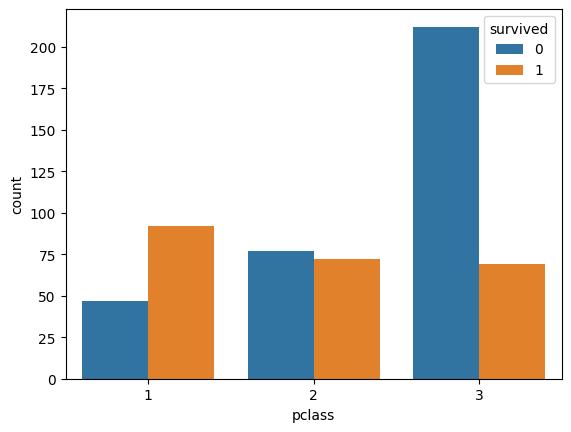

In [81]:
sns.countplot(
    data=titanic.iloc[train_indexs[0]],
    x='pclass',
    hue='survived',
)

<Axes: xlabel='pclass', ylabel='count'>

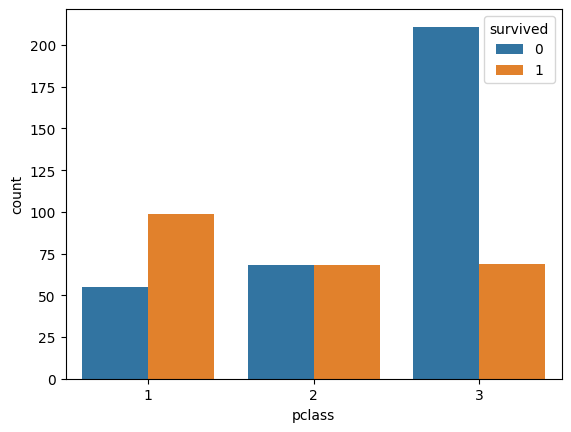

In [82]:
sns.countplot(
    data=titanic.iloc[train_indexs[1]],
    x='pclass',
    hue='survived',
)

## Stratified K-fold

<img src="https://images.prismic.io/turing/65a532e87a5e8b1120d58778_image1_11zon_10bb3bd085.webp?auto=format,compress" width="700" height="400"/>

<br>

일반적인 K-fold의 단점은 fold 생성 시 데이터를 임의 분할한다는 점. <br>
데이터 내 클래스가 unbalanced인 경우 일부 fold에서는 클래스를 할당받지 못하거나 매우 적은 class를 할당받을 수 있음. <br>
    -> 이는 round별 모델의 성능의 편차가 커지는 결과 초래 <br>
이를 방지하기 위해 **클래스별 비율이 동일하게 fold 분할**.

<br>

**사용 방법**

> ```python
> from sklearn.model_selection import StratifiedKFold
>
> stratified_k_fold = StratifiedKFold()  # n_splits: 5 (default)
> for i, (train_index, test_index) in enumerate(stratified_k_fold.split(X, y)):
>   train_x = data[train_index]
>   train_y = data[test_index]
>   ...
> ```

<br>

**Parameters of StratifiedKFold**
- shuffle: 데이터를 섞어서 fold 생성
- random state: 재현성을 위한 시드 넘버
- n_splits: 몇 개의 fold로 구성할 것인지 설정

In [87]:
titanic.survived.value_counts() / len(titanic.survived)

survived
0    0.595506
1    0.404494
Name: count, dtype: float64

In [88]:
results = {}
k_fold = KFold(random_state=seed, shuffle=True)
for i, (train_index, test_index) in enumerate(k_fold.split(titanic)):
    temp = titanic.iloc[train_index]
    test = titanic.iloc[test_index]
    train, valid = train_test_split(temp, test_size=len(test)/len(temp))

    print(f'{i+1}-fold')
    display(train.survived.value_counts() / len(train.survived))
    display(valid.survived.value_counts() / len(valid.survived))
    display(test.survived.value_counts() / len(test.survived))

1-fold


survived
0    0.607981
1    0.392019
Name: count, dtype: float64

survived
0    0.58042
1    0.41958
Name: count, dtype: float64

survived
0    0.573427
1    0.426573
Name: count, dtype: float64

2-fold


survived
0    0.586854
1    0.413146
Name: count, dtype: float64

survived
0    0.601399
1    0.398601
Name: count, dtype: float64

survived
0    0.615385
1    0.384615
Name: count, dtype: float64

3-fold


survived
0    0.598131
1    0.401869
Name: count, dtype: float64

survived
0    0.612676
1    0.387324
Name: count, dtype: float64

survived
0    0.570423
1    0.429577
Name: count, dtype: float64

4-fold


survived
0    0.588785
1    0.411215
Name: count, dtype: float64

survived
0    0.626761
1    0.373239
Name: count, dtype: float64

survived
0    0.584507
1    0.415493
Name: count, dtype: float64

5-fold


survived
0    0.598131
1    0.401869
Name: count, dtype: float64

survived
0    0.549296
1    0.450704
Name: count, dtype: float64

survived
0    0.633803
1    0.366197
Name: count, dtype: float64

In [127]:
results = {}
stratified_k_fold = StratifiedKFold(random_state=seed, shuffle=True)
for i, (train_index, test_index) in enumerate(stratified_k_fold.split(titanic, titanic.survived)):
    temp = titanic.iloc[train_index]
    test = titanic.iloc[test_index]
    train, valid = train_test_split(temp, test_size=len(test)/len(temp))

    lgbm = LGBMClassifier(verbose=0)
    lgbm.fit(
        train.drop(columns=['survived']), train.survived,
        eval_set=(valid.drop(columns=['survived']), valid.survived)
    )

    confusion_matrix_result = confusion_matrix(
        np.where(test.survived==0, 1, 0),
        np.where(lgbm.predict(test.drop(columns=['survived']))==0, 1, 0),
    )
    TP = confusion_matrix_result[0, 0]
    FN = confusion_matrix_result[0, 1]
    FP = confusion_matrix_result[1, 0]
    TN = confusion_matrix_result[1, 1]

    precision = TP / (TP+FP)
    recall = TP / (TP+FN)
    f1 = 2*precision*recall / (precision+recall)
    accuracy = (TP+TN) / (TP+TN+FP+FN)

    results.update({
        f'fold{i+1}': {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'accuracy': accuracy,
        }
    })

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [128]:
for fold, result in results.items():
    print(f'{fold}: {result}')

fold1: {'precision': 0.8431372549019608, 'recall': 0.7413793103448276, 'f1': 0.7889908256880734, 'accuracy': 0.8391608391608392}
fold2: {'precision': 0.803921568627451, 'recall': 0.7068965517241379, 'f1': 0.7522935779816514, 'accuracy': 0.8111888111888111}
fold3: {'precision': 0.7796610169491526, 'recall': 0.8070175438596491, 'f1': 0.7931034482758621, 'accuracy': 0.8309859154929577}
fold4: {'precision': 0.7317073170731707, 'recall': 0.5263157894736842, 'f1': 0.6122448979591836, 'accuracy': 0.7323943661971831}
fold5: {'precision': 0.65625, 'recall': 0.7241379310344828, 'f1': 0.6885245901639345, 'accuracy': 0.7323943661971831}


extreme small case

In [119]:
titanic2 = titanic.copy()

In [120]:
titanic2.loc[titanic2.loc[titanic2.survived == 1, 'survived'].index[:280], 'survived'] = 0

In [121]:
titanic2.survived.value_counts() / len(titanic2)

survived
0    0.988764
1    0.011236
Name: count, dtype: float64

In [123]:
results = {}
k_fold = KFold(random_state=seed, shuffle=True)
for i, (train_index, test_index) in enumerate(k_fold.split(titanic2)):
    temp = titanic2.iloc[train_index]
    test = titanic2.iloc[test_index]
    train, valid = train_test_split(temp, test_size=len(test)/len(temp))

    print(f'{i+1}-fold')
    display(train.survived.value_counts() / len(train.survived))
    display(valid.survived.value_counts() / len(valid.survived))
    display(test.survived.value_counts() / len(test.survived))

1-fold


survived
0    0.995305
1    0.004695
Name: count, dtype: float64

survived
0    0.972028
1    0.027972
Name: count, dtype: float64

survived
0    0.986014
1    0.013986
Name: count, dtype: float64

2-fold


survived
0    0.988263
1    0.011737
Name: count, dtype: float64

survived
0    0.993007
1    0.006993
Name: count, dtype: float64

survived
0    0.986014
1    0.013986
Name: count, dtype: float64

3-fold


survived
0    0.992991
1    0.007009
Name: count, dtype: float64

survived
0    0.978873
1    0.021127
Name: count, dtype: float64

survived
0    0.985915
1    0.014085
Name: count, dtype: float64

4-fold


survived
0    0.983645
1    0.016355
Name: count, dtype: float64

survived
0    0.992958
1    0.007042
Name: count, dtype: float64

survived
0    1.0
Name: count, dtype: float64

5-fold


survived
0    0.992991
1    0.007009
Name: count, dtype: float64

survived
0    0.978873
1    0.021127
Name: count, dtype: float64

survived
0    0.985915
1    0.014085
Name: count, dtype: float64

In [124]:
results = {}
stratified_k_fold = StratifiedKFold(random_state=seed, shuffle=True)
for i, (train_index, test_index) in enumerate(stratified_k_fold.split(titanic2, titanic2.survived)):
    temp = titanic2.iloc[train_index]
    test = titanic2.iloc[test_index]
    train, valid = train_test_split(temp, test_size=len(test)/len(temp))

    print(f'{i+1}-fold')
    display(train.survived.value_counts() / len(train.survived))
    display(valid.survived.value_counts() / len(valid.survived))
    display(test.survived.value_counts() / len(test.survived))

1-fold


survived
0    0.99061
1    0.00939
Name: count, dtype: float64

survived
0    0.986014
1    0.013986
Name: count, dtype: float64

survived
0    0.986014
1    0.013986
Name: count, dtype: float64

2-fold


survived
0    0.988263
1    0.011737
Name: count, dtype: float64

survived
0    0.993007
1    0.006993
Name: count, dtype: float64

survived
0    0.986014
1    0.013986
Name: count, dtype: float64

3-fold


survived
0    0.990654
1    0.009346
Name: count, dtype: float64

survived
0    0.978873
1    0.021127
Name: count, dtype: float64

survived
0    0.992958
1    0.007042
Name: count, dtype: float64

4-fold


survived
0    0.983645
1    0.016355
Name: count, dtype: float64

survived
0    1.0
Name: count, dtype: float64

survived
0    0.992958
1    0.007042
Name: count, dtype: float64

5-fold


survived
0    0.988318
1    0.011682
Name: count, dtype: float64

survived
0    0.992958
1    0.007042
Name: count, dtype: float64

survived
0    0.985915
1    0.014085
Name: count, dtype: float64

## Walk Forward (Anchor)

<img src="https://media.licdn.com/dms/image/C4D12AQEHWXK8cuV07w/article-inline_image-shrink_1000_1488/0/1637321417060?e=2147483647&v=beta&t=RzRHzXkbL1mBFMUjcbLS0EsOGZEGiISOM792YSaTo4A" width="700" height="400"/>

<br>

시계열 데이터의 특성 상 sequential한 데이터의 성질을 잃어버리면 안 됨. <br>
하지만 기본적인 cross-validation의 fold는 이를 임의로 섞기에 sequential한 정보를 잃어버림. <br>
이러한 시계열의 특징을 살려 cross-validation을 진행하는 것이 Timeseries Cross-Validation. <br>

Walk Forward (Anchor)은 시작 위치의 값이 이동하는 것이 아니라, 처음 위치에서부터 fold를 누적으로 확대. <br>
test size는 일반적으로 고정되어 있음.

<br>

**사용 방법**

> ```python
> from sklearn.model_selection import TimeSeriesSplit
>
> time_series_split = TimeSeriesSplit()  # n_splits: 5 (default)
> for i, (train_index, test_index) in enumerate(time_series_split.split(X)):
>   train_x = data[train_index]
>   train_y = data[test_index]
>   ...
> ```

<br>

**Parameters of TimeSeriesSplit**
- shuffle: 데이터를 섞어서 fold 생성
- random state: 재현성을 위한 시드 넘버
- n_splits: 몇 개의 fold로 구성할 것인지 설정
- max_train_size: 최대 학습 개수 설정. (non-anchor에서 사용)
- test_size: test 구간의 크기 설정
- gap: train과 test 사이에 몇 개의 데이터 간격을 둘 건지 설정 (purging을 목적으로 사용)

In [133]:
time_series_split = TimeSeriesSplit()
for i, (train_index, test_index) in enumerate(time_series_split.split(titanic)):
    print(f'{i+1} fold')
    print(train_index)
    print(test_index)

1 fold
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121]
[122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239]
2 fold
[  0   1  

## Walk Forward (non-Anchor)

<img src="https://media.licdn.com/dms/image/C4D12AQEp3jwtWRs3Ww/article-inline_image-shrink_1000_1488/0/1637321444844?e=2147483647&v=beta&t=q7NS-8RiHPeeuwfymNsMyYL8ce1bwsDjrUL-wGyqVQ4" width="700" height="400"/>

<br>

non-anchor는 시작 위치를 고정하지 않는 것으로 구간을 오른쪽으로 점차 옮기면서 확인하는 것을 의미. <br>
시계열의 연속성은 살리면서 특정 구간에 해당하는 데이터로만 검정 시 사용. <br>

<br>

**사용 방법**
> ```python
> from sklearn.model_selection import TimeSeriesSplit
>
> time_series_split = TimeSeriesSplit(max_train_size=10, test_size=3)  # n_splits: 5 (default)
> for i, (train_index, test_index) in enumerate(time_series_split.split(X)):
>   train_x = data[train_index]
>   train_y = data[test_index]
>   ...
> ```


In [136]:
time_series_split = TimeSeriesSplit(max_train_size=100, test_size=100)
for i, (train_index, test_index) in enumerate(time_series_split.split(titanic)):
    print(f'{i+1} fold')
    print(train_index)
    print(len(train_index))
    print(test_index)
    print(len(test_index))

1 fold
[112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211]
100
[212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247
 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265
 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283
 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301
 302 303 304 305 306 307 308 309 310 311]
100
2 fold
[212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247
 248 249 250 251 2

## Purged Cross-Validation

<img src="https://www.researchgate.net/publication/364022775/figure/fig9/AS:11431281115413786@1674878761351/Combinatorial-embargoed-purging-K-fold-CV-The-blue-and-red-bars-indicate-the-training.png" width="700" height="400"/>


Walk forward 방법이 아래와 같은 단점 존재
1. Data Leakage 문제: Walk forward는 시간에 따라 모델을 반복적으로 훈련하고 검증하기 때문에, 최신 데이터로 인해 데이터 유출 문제 발생 가능성 존재. <br>
    -> 모델이 미래 정보를 활용하여 예측하려고 시도하게 만들어 정확한 성능 평가를 방해할 수 있음
2. 편향된 모델 성능: 매 시간대에서 모델을 최적화하고 검증하는 과정에서, 해당 시간대에 최적화된 모델을 선택하게 되어 편향된 모델 성능 추정 발생 가능성 존재.
    -> 이는 모델이 특정 시간대에서만 잘 작동하도록 만들어질 수 있을 가능성 존재

위의 문제를 해결하기 위해 cross-validation 사용했었지만 아래와 같은 예제에서 문제 발생 <br>
    ex) 2010~2019년 S&P500이 활황이었을 때 데이터를 학습 후 2007-2009년 금융 위기의 데이터를 테스트 한다고 할 때 테스트 데이터에서 일부 정보 유출이 발생하여 잘못된 결과를 도출할 가능성이 존재

<br>

Combinatorial Purged Cross-Validation(CPCV)은 Walk Forward와 Cross-Validation이 단일 경로만을 테스트하는 단점을 보완. <br>
CPCV를 통해 사전에 특정된 서로 다른 train/test 셋의 조합을 통해 bactesting path를 생성. <br>

<br>

<img src="https://cdn-images-1.medium.com/proxy/1*-zIcqDu_jnPPkBAcEtQ4HA.png" width="700" height="400"/>


### Purging

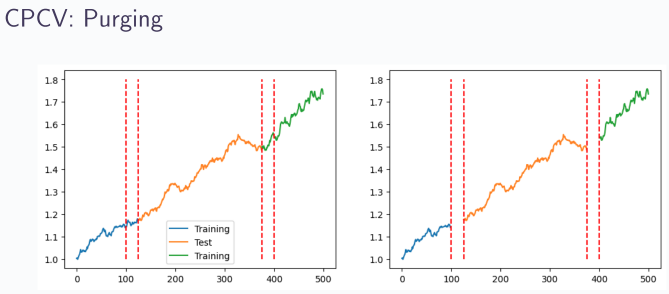

<br>

시계열 데이터는 이전 자신과의 연관도가 높기에 테스트 데이터 부근의 학습 데이터를 제거하여 학습 데이터로의 leakage 방지.

### Embargoing

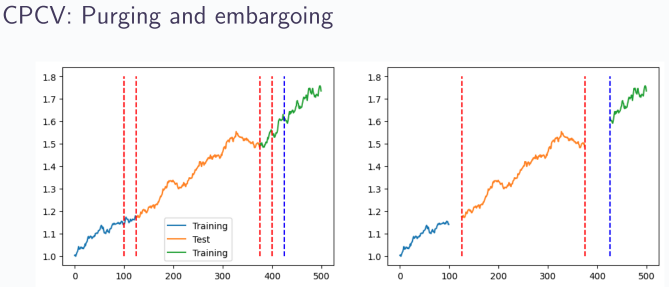

<br>

test 구간과 연관성이 높은 train의 앞 부분을 제거했다고 해도 여전히 그 연관성이 높을 수 있음. <br>
이 경우 추가적으로 연관성을 제거하기 위해 학습 데이터의 앞 부분 일부를 제거하는 것 <br>

# Practice

## Stratified K-Fold

In [ ]:
# diamonds 데이터 셋에서 cut을 맞추는 lightgbm모델 작성
# target: cut, fair: 1, otherwise: 0
# stratified cv를 적용하여 fold별 performance를 비교
# cv별 random search를 통하여 hyperparameter tuning 및 parameter 비교

In [151]:
diamonds = sns.load_dataset('diamonds')
diamonds['cut'] = np.where(diamonds['cut']=='Fair', 1, 0)

results = {}
stratified_k_fold = StratifiedKFold()
for i, (train_index, test_index) in enumerate(stratified_k_fold.split(
    diamonds.drop(columns='cut'), diamonds['cut']
    )):
    train = diamonds.iloc[train_index]
    train, valid = train_test_split(
        train,
        test_size=len(test)/len(train),
        random_state=seed,
    )
    test = diamonds.iloc[test_index]
    lgbm = LGBMClassifier().fit(
        train.drop(columns=['cut']),
        train['cut'],
        eval_set=(valid.drop(columns=['cut']), valid['cut']),
    )

    confusion_matrix_result = confusion_matrix(
        test['cut'],
        lgbm.predict(test.drop(columns=['cut'])),
    )
    TP = confusion_matrix_result[0, 0]
    FN = confusion_matrix_result[0, 1]
    FP = confusion_matrix_result[1, 0]
    TN = confusion_matrix_result[1, 1]

    precision = TP / (TP+FP)
    recall = TP / (TP+FN)
    f1 = 2*precision*recall / (precision+recall)
    accuracy = (TP+TN) / (TP+TN+FP+FN)

    results.update({
        f'fold{i+1}': {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'accuracy': accuracy,
        }
    })

In [155]:
for fold, result in results.items():
    print(f'{fold}: {result}')

fold1: {'precision': 0.9987123081875737, 'recall': 0.8892604624498376, 'f1': 0.9408137477887288, 'accuracy': 0.8914534668149796}
fold2: {'precision': 0.9845812855353185, 'recall': 0.9762086757118288, 'f1': 0.9803771050232692, 'accuracy': 0.9620875046347794}
fold3: {'precision': 0.9853959222380275, 'recall': 0.9928339384674183, 'f1': 0.9891009471229356, 'accuracy': 0.9787727104189841}
fold4: {'precision': 0.9800487073810416, 'recall': 0.9997133575386967, 'f1': 0.9897833695960646, 'accuracy': 0.9799777530589544}
fold5: {'precision': 0.996903725205612, 'recall': 0.9844257596025224, 'f1': 0.9906254506994856, 'accuracy': 0.981924360400445}


In [ ]:
## IMDB

# 1. day32 IMDB 모델의 confusion matrix 확인
    # 1.1 모델 학습
    # 1.2 test data에 대해서 confusion matrix 확인
# 2. cross validation을 통하여 5개 fold의 결과 확인 및 비교
    # 2.1 fold별 모델 학습
    # 2.2 모델 결과 비교